# Import Dependencies

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import optim
import time
from torch.autograd import Variable
%matplotlib inline

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load Data

In [3]:
data_dir = "mliii-assignment2" # Path to data directory
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train'))) == len(labels))

In [4]:
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [5]:
X = labels.id
y = labels.breed

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2, random_state=SEED, stratify=y)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid)

In [6]:
X_train

9176    e673bb6ca717b8dffe3b5ba35da07a83
9076    e4245709e4060e08146b5fe1af72385d
3248    508b1aa3c6a435243aa3b2c1b09fb21e
6091    99ce3a403e4d0a7f57c2c520603aad50
2596    40769dc3fc3727345a2359003df5b677
                      ...               
9506    ee3ffc332086a4e74209a97b7b1330da
3308    520ff370916dba1b34cbc94e07748805
7797    c30c5194bffad8dfbad7e8db70ad449e
930     16d21426a864e73050afda40bf1fddc6
5347    868decd906bb483bac17a005a3f06bc3
Name: id, Length: 8177, dtype: object

In [7]:
from torchvision.transforms import Resize, ToTensor, Normalize

means = np.load('means.npy')
stds = np.load('stds.npy')
class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.resize = Resize((224,224))
        self.normalize = Normalize(means, stds)
        self.trans = transforms.Compose([
            transforms.AugMix(),   
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        image = self.resize(image)
        image = self.trans(image)
        image = self.normalize(image)
#         if self.transforms is not None:
#             image = self.transforms(image)
        
        return image, label

class Dataset_Interpreter_crop(Dataset):
    def __init__(self, data_path, file_names, labels=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.resize = Resize((224, 224))
        self.normalize = Normalize(means, stds)
        self.trans = transforms.Compose([
            transforms.TenCrop((100, 100)),
            transforms.Lambda(lambda crops: [transforms.Resize((224, 224))(crop) for crop in crops]),
            transforms.Lambda(lambda crops: [transforms.AugMix()(crop) for crop in crops]),
            transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop).float() for crop in crops])),
        ])
        self.to_tensor = ToTensor()
        
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        image = self.resize(image)
        cropped_images = self.trans(image)
        transformed_images = self.normalize(cropped_images)
        
        return transformed_images, label
    
class Dataset_Interpreter_valid_test(Dataset):
    def __init__(self, data_path, file_names, labels=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.resize = Resize((224,224))
        self.normalize = Normalize(means, stds)
        self.trans = transforms.Compose([   
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        image = self.resize(image)
        image = self.trans(image)
        image = self.normalize(image)
#         if self.transforms is not None:
#             image = self.transforms(image)
        
        return image, label

In [8]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')
N_IMAGES = 9

train_data = Dataset_Interpreter(data_path=data_dir+'/train/', file_names=X_train, labels=y_train)
crop_data = Dataset_Interpreter_crop(data_path=data_dir+'/train/', file_names=X_train, labels=y_train)
valid_data = Dataset_Interpreter_valid_test(data_path=data_dir+'/train/', file_names=X_valid, labels=y_valid)
#test_data = Dataset_Interpreter_valid_test(data_path=data_dir+'/train/', file_names=X_test, labels=y_test)
images = [(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]] 
#plot_images(images)

In [9]:
train_data[0][0].size()

torch.Size([3, 224, 224])

In [10]:
crop_data[0][0].size()

torch.Size([10, 3, 224, 224])

In [11]:
len(train_data)

8177

In [12]:
train_data[0]

(tensor([[[-1.8370, -1.8340, -1.8315,  ..., -1.8372, -1.8375, -1.8375],
          [-1.8369, -1.8342, -1.8314,  ..., -1.8374, -1.8374, -1.8375],
          [-1.8368, -1.8346, -1.8312,  ..., -1.8379, -1.8376, -1.8375],
          ...,
          [-1.8456, -1.8457, -1.8456,  ..., -1.8461, -1.8460, -1.8458],
          [-1.8455, -1.8457, -1.8456,  ..., -1.8460, -1.8460, -1.8458],
          [-1.8456, -1.8456, -1.8451,  ..., -1.8458, -1.8459, -1.8457]],
 
         [[-1.7799, -1.7768, -1.7741,  ..., -1.7798, -1.7801, -1.7802],
          [-1.7797, -1.7770, -1.7741,  ..., -1.7802, -1.7804, -1.7805],
          [-1.7797, -1.7774, -1.7741,  ..., -1.7810, -1.7810, -1.7810],
          ...,
          [-1.7870, -1.7872, -1.7872,  ..., -1.7893, -1.7892, -1.7891],
          [-1.7872, -1.7874, -1.7874,  ..., -1.7892, -1.7892, -1.7891],
          [-1.7875, -1.7875, -1.7872,  ..., -1.7891, -1.7891, -1.7889]],
 
         [[-1.5180, -1.5166, -1.5156,  ..., -1.5190, -1.5189, -1.5188],
          [-1.5178, -1.5166,


def combine_crop(data):
    reformatted_data = []  # Initialize an empty list to store reformatted data
    
    for i in range(len(data)):
        for j in range(10):
            image = data[i][0][j].to('cuda')
            label = data[i][1]
            reformatted_data.append((image, label))  # Append the image and label as a tuple
    
    return reformatted_data  # Return the list of (image, label) tuples

crop = combine_crop(crop_data)
len(crop)

In [13]:
data = torch.unbind(crop_data[0][0], dim=0)
data[0]

tensor([[[ 0.2665,  0.4185,  0.7985,  ...,  0.9201,  0.9353,  0.9353],
         [ 0.2513,  0.4185,  0.7985,  ...,  0.9353,  0.9505,  0.9505],
         [ 0.2361,  0.4337,  0.7681,  ...,  0.9809,  0.9961,  0.9961],
         ...,
         [-1.6637, -1.6637, -1.6485,  ..., -0.9342, -0.8430, -0.7974],
         [-1.6637, -1.6637, -1.6637,  ..., -0.9342, -0.9038, -0.8734],
         [-1.6637, -1.6637, -1.6789,  ..., -0.9494, -0.9190, -0.8734]],

        [[ 0.4300,  0.6007,  0.9576,  ...,  0.1506,  0.1661,  0.1661],
         [ 0.3989,  0.6007,  0.9576,  ...,  0.1661,  0.1817,  0.1817],
         [ 0.3834,  0.6007,  0.9421,  ...,  0.2127,  0.2282,  0.2282],
         ...,
         [-1.4479, -1.4634, -1.5255,  ..., -0.9668, -0.8737, -0.8271],
         [-1.3548, -1.3858, -1.4944,  ..., -0.9823, -0.9357, -0.8737],
         [-1.3237, -1.3548, -1.4789,  ..., -0.9823, -0.9513, -0.9047]],

        [[ 0.1517,  0.2279,  0.3957,  ..., -0.2447, -0.2295, -0.2142],
         [ 0.1517,  0.2432,  0.3957,  ..., -0

crop = []  
    
for i in range(len(crop_data)):
    data = torch.unbind(crop_data[i][0], dim=0)
    label = crop_data[i][1]
    for j in range(10):
        image = data[j].numpy()
        crop.append((image, label))  # Append the image and label as a tuple
    
len(crop)

len(crop)

channel_1_mean = np.mean([train_data[x][0][:,:,0] for x in range(0, len(train_data))])

channel1 = [train_data[x][0][:,:,0] for x in range(0, len(train_data))]

channel2 = [train_data[x][0][:,:,1] for x in range(0, len(train_data))]
channel3 = [train_data[x][0][:,:,2] for x in range(0, len(train_data))]

channel_2_mean = np.mean(channel2)
channel_3_mean = np.mean(channel3)
channel_1_std = np.std(channel1)
channel_2_std = np.std(channel2)
channel_3_std = np.std(channel3)

means = np.array([channel_1_mean, channel_2_mean, channel_3_mean])
stds = np.array([channel_1_std, channel_2_std, channel_3_std])
np.save('stds', stds)
np.save('means', means)

# Data Preprocessing

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Model

In [15]:
# Create model here 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

model_ft = models.resnet50(weights='IMAGENET1K_V2')
num_classes=120
num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # Additional linear layer with 256 output features
    nn.LeakyReLU(negative_slope=0.01, inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.2),               # Dropout layer with 20% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.0001, weight_decay=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
for param in model_ft.parameters():
    param.requires_grad = False
    
for param in model_ft.fc.parameters():
    param.requires_grad = True

In [16]:
#Load trained model:
model_ft = models.resnet50()
num_classes=120
num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # Additional linear layer with 256 output features
    nn.LeakyReLU(negative_slope=0.01, inplace=True),        
    nn.Dropout(0.2),               # Dropout layer with 20% probability
    #nn.Dropout(0.5),               # Dropout layer with 50% probability
    nn.Linear(256, num_classes)    # Final prediction fc layer
)

#Load single GPU model
#model_ft.load_state_dict(torch.load('saved_model_final_v2.pth'))
model_ft.load_state_dict(torch.load('saved_model_final_v5.pth'))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0.0005)
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.0001, weight_decay=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
for param in model_ft.parameters():
    param.requires_grad = False
    
for param in model_ft.fc.parameters():
    param.requires_grad = True
    
#Load multi-gpu model
#model_ft = nn.DataParallel(model_ft)
# model_ft.load_state_dict(torch.load('saved_model_final.pth'))
# model_ft = model_ft.to(device)

In [19]:
batch_size = 128

# data loader
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = False)
#test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)
crop_loader = DataLoader(crop_data, batch_size = batch_size, shuffle = False)

In [29]:
test_crop = Dataset_Interpreter_crop(data_path=data_dir+'/train/', file_names=X_train[0:250], labels=y_train[0:250])
crop_test = DataLoader(test_crop, batch_size = batch_size, shuffle = False)

In [18]:
train_losses = []
valid_losses = []
def train_model(model, optimizer, train_loader, valid_loader, loss_module, num_epochs=100):
    
    min_valid_loss = 0.0
    model.eval()     
    for data_inputs, data_labels in valid_loader:
        data_inputs = data_inputs.to(device)
        data_labels = np.array(data_labels)
        data_labels = torch.from_numpy(data_labels)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels)
        min_valid_loss += loss.item()
        
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        # Set model to train mode
        model.train()
        for data_inputs, data_labels in train_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = np.array(data_labels)
            data_labels = torch.from_numpy(data_labels)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
#             inputs = data_inputs.view(-1, 3, 224, 224)  
#             preds = model(inputs)
#             preds = preds.view(10, -1, 120)
#             preds = preds.max(dim=0)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            #loss = loss_module(preds[0], data_labels)
            loss = loss_module(preds, data_labels)
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Add to loss
            train_loss += loss.item()
            
        #Validation Loop
        valid_loss = 0.0
        model.eval()     
        for data_inputs, data_labels in valid_loader:
            data_inputs = data_inputs.to(device)
            data_labels = np.array(data_labels)
            data_labels = torch.from_numpy(data_labels)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)
            valid_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(valid_loader))
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model_final_v3.pth')
#train_model(model_ft, optimizer_ft, crop_loader, valid_loader, criterion)
#train_model(model_ft, optimizer_ft, crop_test, valid_loader, criterion)
train_model(model_ft, optimizer_ft, train_loader, valid_loader, criterion)

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.75 GiB total capacity; 10.42 GiB already allocated; 9.19 MiB free; 10.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

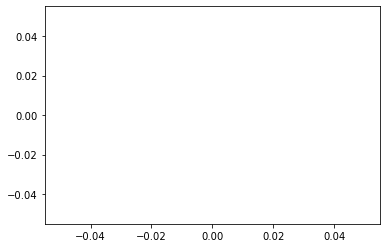

In [31]:
plt.plot(train_losses)

In [ ]:
plt.plot(valid_losses)

In [18]:
import torch.nn.functional as F

def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = F.softmax(preds, dim=1)
            max_prob_labels = torch.argmax(preds, dim=1)
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (max_prob_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

# Assuming you have already defined 'model' and 'train_loader'
eval_model(model_ft, train_loader)
eval_model(model_ft, valid_loader)
eval_model(model_ft, test_loader)

KeyboardInterrupt: 

In [20]:
import torch.nn.functional as F

def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    total_loss = 0.0
    for data_inputs, data_labels in data_loader:
        data_inputs = data_inputs.to(device)
        data_labels = np.array(data_labels)
        data_labels = torch.from_numpy(data_labels)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels)
        total_loss += loss.item()

    print(f'Loss: {total_loss / len(data_loader)}')
    
# Assuming you have already defined 'model' and 'train_loader'

eval_model(model_ft, train_loader, criterion)
eval_model(model_ft, valid_loader, criterion)
eval_model(model_ft, test_loader, criterion)

Loss: 0.053088414926605765
Loss: 0.6679373476654291


NameError: name 'test_loader' is not defined

def eval_crop_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            inputs = data_inputs.view(-1, 3, 224, 224)  
            preds = model(inputs)
            preds = preds.view(10, -1, 120)
            preds = preds.max(dim=0)
            preds = F.softmax(preds[0], dim=1)
            max_prob_labels = torch.argmax(preds, dim=1)
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (max_prob_labels == data_labels).sum().item()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")
    
eval_crop_model(model_ft, crop_loader)

# Submission CSV

In [21]:
import pandas as pd

class Dataset_Interpreter_test(Dataset):
    def __init__(self, data_path, file_names, labels=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        self.resize = Resize((224,224))
        self.normalize = Normalize(means, stds)
        self.trans = transforms.Compose([   
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        image = self.resize(image)
        image = self.trans(image)
        image = self.normalize(image)
#         if self.transforms is not None:
#             image = self.transforms(image)
        
        return image
    
files = [f for f in os.listdir(data_dir + '/test/') if os.path.isfile(os.path.join(data_dir, 'test', f)) and f.endswith(".jpg")]
files = {'id': files}
files = pd.DataFrame(files)
test_data = Dataset_Interpreter_test(data_path=data_dir+'/test/', file_names=files['id'])    
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

def test_model(model, data_loader):
    model.eval() # Set model to eval mode
    predictions = []

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs in data_loader:

            # Determine prediction of model on dev set
            data_inputs = data_inputs.to(device)
            #data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = F.softmax(preds, dim=1)
            for i in preds:
                predictions.append(i)
        
    return predictions
# Assuming you have already defined 'model' and 'train_loader'
raw_predictions = test_model(model_ft, test_loader)

predictions = []
for i in range(0, len(raw_predictions)):
    prediction = raw_predictions[i].cpu()
    image_id = files.iloc[i]['id']
    image_id = image_id.split('.jpg')[0]
    predictions.append({'image_id': image_id, 'probs': prediction})
    
# predictions = {
#     '000621fb3cbb32d8935728e48679680e': [0.01, 0.02, ...],  # Replace with actual probabilities
#     # ... add more predictions
# }

In [22]:
def generate_submission(predictions, sample_submission_path, output_path):
    """
    Generate a Kaggle submission file based on the given predictions.

    Parameters:
    - predictions: A dictionary with image ids as keys and a list of 120 probabilities as values.
    - sample_submission_path: Path to the provided sample submission file.
    - output_path: Path to save the generated submission file.
    """
    # Load the sample submission
    sample_submission = pd.read_csv(sample_submission_path)
    
    # Replace the sample probabilities with the actual predictions
    for i in range(0, len(predictions)):
        prediction = predictions[i]
        preds = prediction['probs'].tolist()
        sample_submission.loc[sample_submission['id'] == prediction['image_id'], sample_submission.columns[1:]] = preds
    # Save the modified sample submission as the final submission
    sample_submission.to_csv(output_path, index=False)
generate_submission(predictions, data_dir + '/sample_submission.csv', 'my_submission.csv')

# Building Second Model

In [19]:
res = models.resnet50(weights='IMAGENET1K_V2')
res = res.to(device)
in_features = res.fc.out_features

class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_hidden2, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)    
        self.act_fn2 = nn.LeakyReLU(negative_slope=0.01, inplace=True)    
        self.linear2 = nn.Linear(num_hidden+1000, num_hidden2)
        self.linear3 = nn.Linear(num_hidden2, num_outputs)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.3)

    def forward(self, x, res_outputs):
        # Perform the calculation of the model to determine the prediction
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool3(x)
        shape1 = x.size()[0]
        x = x.reshape((shape1, 2352))
        x = self.linear1(x)
        x = self.act_fn1(x)
        x = self.drop1(x)
        x = self.linear2(torch.cat((x.T, res_outputs.T)).T)
        x = self.act_fn2(x)
        x = self.drop2(x)
        x = self.linear3(x)
           # x = self.softmax(x)
        return x
model = SimpleClassifier(num_inputs=2352, num_hidden=200, num_hidden2= 500, num_outputs=120)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('saved_model_test.pth'))
model = model.to(device)

In [19]:
train_losses = []
valid_losses = []
test = Dataset_Interpreter(data_path=data_dir+'/train/', file_names=X_train[0:250], labels=y_train[0:250])
train_test = DataLoader(test, batch_size = batch_size, shuffle = False)
def train_model(res, model, optimizer, train_loader, valid_loader, loss_module, num_epochs=100):
    
    min_valid_loss = 0.0
    model.eval()     
    for data_inputs, data_labels in valid_loader:
        data_inputs = data_inputs.to(device)
        data_labels = np.array(data_labels)
        data_labels = torch.from_numpy(data_labels)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = res(data_inputs)
        preds = model(data_inputs, preds)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels)
        min_valid_loss += loss.item()
        
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        # Set model to train mode
        model.train()
        for data_inputs, data_labels in train_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = np.array(data_labels)
            data_labels = torch.from_numpy(data_labels)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
#             inputs = data_inputs.view(-1, 3, 224, 224)  
#             preds = model(inputs)
#             preds = preds.view(10, -1, 120)
#             preds = preds.max(dim=0)
            preds = res(data_inputs)
            preds = model(data_inputs, preds)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            #loss = loss_module(preds[0], data_labels)
            loss = loss_module(preds, data_labels)
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Add to loss
            train_loss += loss.item()
            
        #Validation Loop
        valid_loss = 0.0
        model.eval()     
        for data_inputs, data_labels in valid_loader:
            data_inputs = data_inputs.to(device)
            data_labels = np.array(data_labels)
            data_labels = torch.from_numpy(data_labels)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = res(data_inputs)
            preds = model(data_inputs, preds)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)
            valid_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
        train_losses.append(train_loss / len(train_loader))
        valid_losses.append(valid_loss / len(valid_loader))
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model_test.pth')
#train_model(model_ft, optimizer_ft, crop_loader, valid_loader, criterion)
#train_model(model_ft, optimizer_ft, crop_test, valid_loader, criterion)
train_model(res, model, optimizer_ft, train_test, valid_loader, criterion)

  1%|          | 1/100 [00:44<1:13:21, 44.45s/it]

Epoch 1 		 Training Loss: 4.801148176193237 		 Validation Loss: 4.796384125947952
Validation Loss Decreased(76.779491--->76.742146) 	 Saving The Model


  2%|▏         | 2/100 [01:29<1:12:49, 44.58s/it]

Epoch 2 		 Training Loss: 4.72734808921814 		 Validation Loss: 4.79609602689743
Validation Loss Decreased(76.742146--->76.737536) 	 Saving The Model


  3%|▎         | 3/100 [02:14<1:12:12, 44.66s/it]

Epoch 3 		 Training Loss: 4.682830810546875 		 Validation Loss: 4.799760311841965


  4%|▍         | 4/100 [02:58<1:11:12, 44.51s/it]

Epoch 4 		 Training Loss: 4.624684572219849 		 Validation Loss: 4.8078301548957825


  5%|▌         | 5/100 [03:43<1:10:36, 44.59s/it]

Epoch 5 		 Training Loss: 4.577681541442871 		 Validation Loss: 4.821329772472382


  6%|▌         | 6/100 [04:28<1:10:06, 44.76s/it]

Epoch 6 		 Training Loss: 4.548324823379517 		 Validation Loss: 4.83911806344986


  7%|▋         | 7/100 [05:13<1:09:28, 44.82s/it]

Epoch 7 		 Training Loss: 4.487006902694702 		 Validation Loss: 4.860602974891663


  8%|▊         | 8/100 [05:57<1:08:23, 44.60s/it]

Epoch 8 		 Training Loss: 4.447624921798706 		 Validation Loss: 4.883562117815018


  9%|▉         | 9/100 [06:42<1:07:52, 44.75s/it]

Epoch 9 		 Training Loss: 4.399871349334717 		 Validation Loss: 4.9048349261283875


  9%|▉         | 9/100 [07:20<1:14:13, 48.94s/it]


KeyboardInterrupt: 

In [20]:
import torch.nn.functional as F

def eval_model(model, res, data_loader, loss_module):
    model.eval() # Set model to eval mode
    total_loss = 0.0
    for data_inputs, data_labels in data_loader:
        data_inputs = data_inputs.to(device)
        data_labels = np.array(data_labels)
        data_labels = torch.from_numpy(data_labels)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = res(data_inputs)
        preds = model(data_inputs, preds)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels)
        total_loss += loss.item()

    print(f'Loss: {total_loss / len(data_loader)}')
    
# Assuming you have already defined 'model' and 'train_loader'
eval_model(model, res, train_loader, criterion)
eval_model(model, res, valid_loader, criterion)
eval_model(model, res, test_loader, criterion)

Loss: 1.6306601464748383
Loss: 2.37012055516243
Loss: 2.362062580883503
